In [2]:
from math import floor
from typing import List, Union

import numpy as np
import scipy
import torch
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## CNN: Feature Extractor 

Convolutional neural networks can automatically learn the features from raw data that are most useful for a particular task. For this reason, it’s common to consider CNN layers as feature extractors: the early layers (those right after the input layer) extract *low-level* features from raw data, and the later layers (often fully connected layers, as in a multilayer perceptron (MLP)) use these features to predict a continuous target value or class label.

<center>
<image height=350 width=650 src='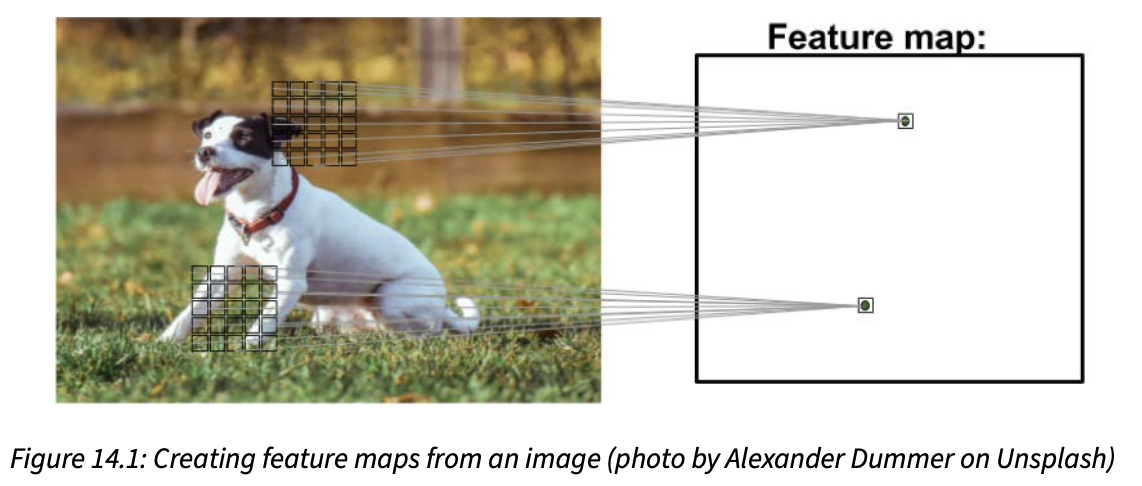'>
</center>

This local patch of pixels is referred to as the **local receptive field**. CNNs will usually perform very well on image-related tasks, and that's largely due to two important ideas:

- **Sparse connectivity**: A single element in the **feature map** is connected to only a small patch of pixels in the input. This is very different from connecting to the whole input image, as in the case of MLPs.
  
- **Parameter sharing**: The same weights are used for different patches of the input image using a sliding window operation, which will be shown later.

The feature extraction ability of CNNs are useful since the visual world is fundamentally spatially hierarchical:

<center>
<image height=400 width=420 src='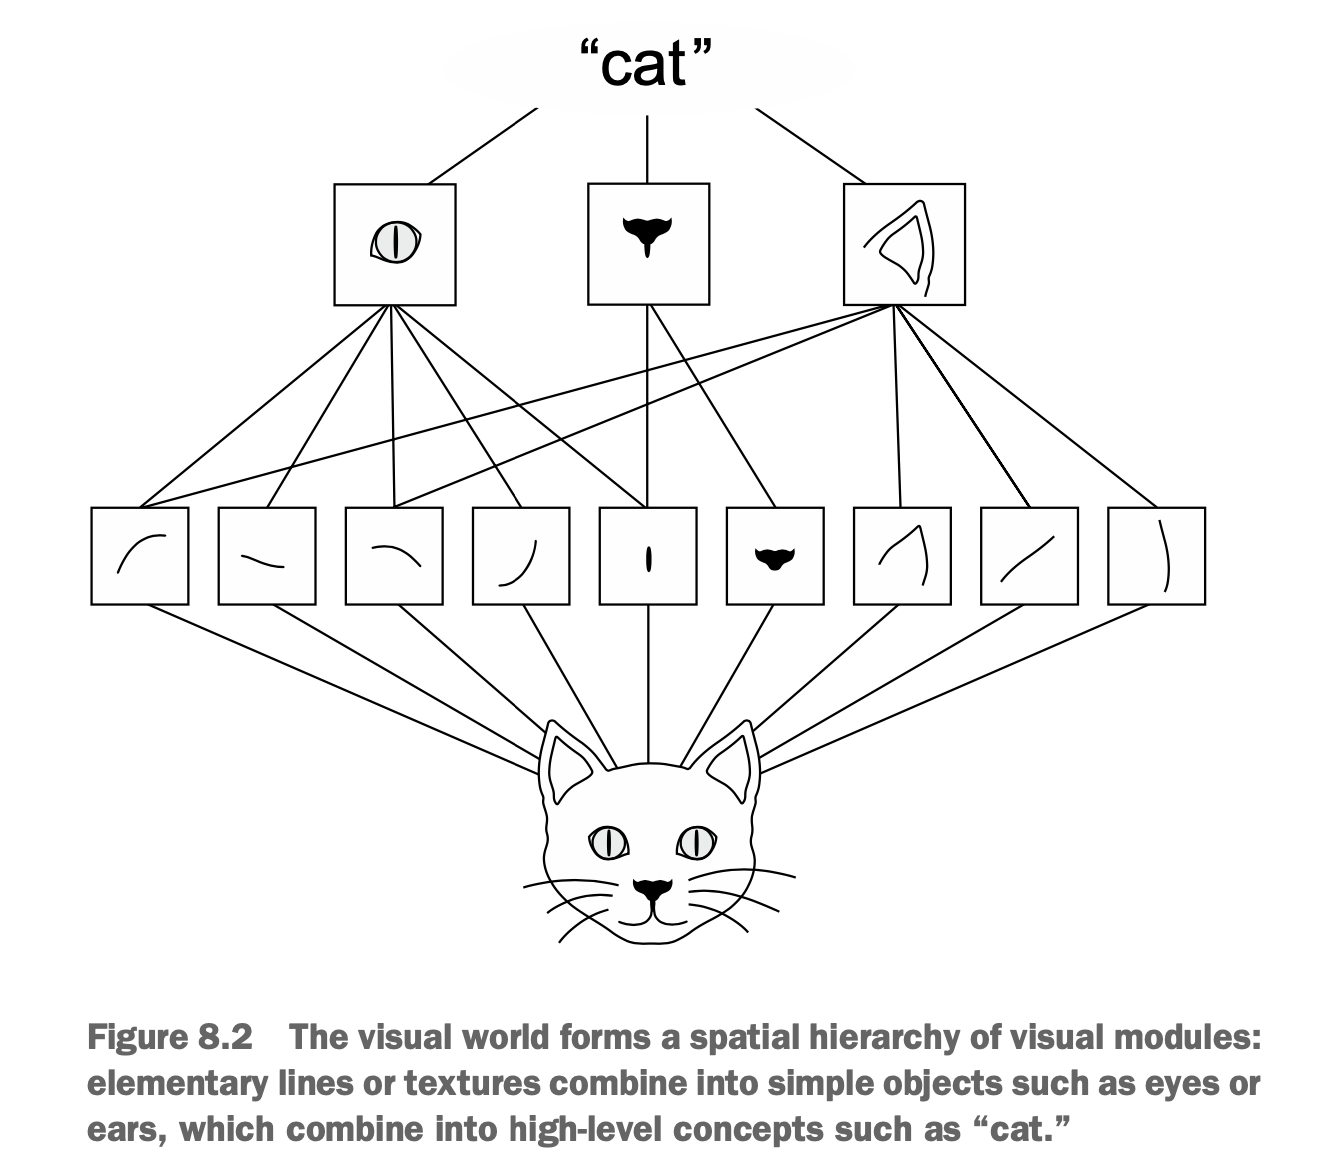'>
</center>

## Convolutions

### Notations

* Subscript will be used to denote the size of a multidimensional array (tensor); for example, $A_{n_1 \times n_2}$ is a two-dimensional array of size $n_1 \times n_2$. 

* Brackets, [ ], will be used to denote the indexing of a multidimensional array. For example, $A[i, j]$ refers to the element at index $i, j$ of matrix $A$.
  
* Furthermore, note that we use a special symbol, $*$, to denote the convolution operation between two vectors or matrices, which is not to be confused with the multiplication operator, $*$, in Python.

### Convolutions in One Dimension

A discrete convolution for two vectors, $x$ and $\boldsymbol{w}$, is denoted by $\boldsymbol{y}=\boldsymbol{x} * \boldsymbol{w}$, in which vector $\boldsymbol{x}$ is our input (sometimes called signal) and $w$ is called the filter or kernel. A discrete convolution is mathematically defined as follows:

$$
\boldsymbol{y}=\boldsymbol{x} * \boldsymbol{w} \rightarrow y[i]=\sum_{k=-\infty}^{+\infty} x[i-k] w[k]
$$

For practical purposes, it is assumed that $x$ and $w$ are filled with zeros. This will result in an output vector, $y$, that also has infinite size and padded only with a finite number of zeros. This process is called **zero-padding** or **padding**. An example padding of a one-dimensional vector, $x$, is shown below. The number of zeros padded on each side is denoted by $p$:


<center>
<image height=200 width=450 src='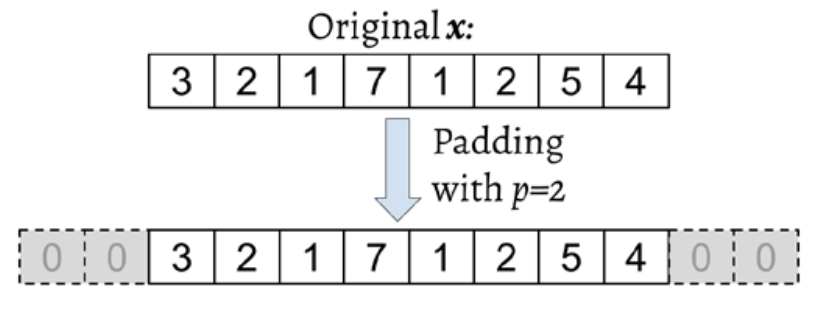'>
</center>

Suppose that the original input, $\boldsymbol{x}$, and filter, $\boldsymbol{w}$, have $n$ and $m$ elements, respectively, where $n \geq m$. The zero-padded vector, $x^p$, has size $n+2p$. The practical formula for computing a discrete convolution will change to the following:

$$
\boldsymbol{y}=\boldsymbol{x} * \boldsymbol{w} \rightarrow y[i]=\sum_{k=0}^{k=m-1} x^p[i+m-k] w[k]
$$

where

* $x$ and $x^{p}$ are vectors with size $n$ and $n + 2p$, respectively

* $w$ is a weight vector with size $m \leq n$

* each element of the output vector $y$ is given by $y[i]$, which is the summation from $0$ to $m-1$

Note that the summation does not depend on the $i$ index, which only indexes the output $y$, and so the number of terms we are summing is independent (and the same) for each element of $y$. The $i$ index can be viewed as being responsible for *sliding* the window across the dimension(s) of the zero-padded input vector $x^p$ so that different patches of it are convolved with the elements of the weight vector.

#### Indexed In Different Directions

Note that the formula for each element $y[i]$ contains a summation between patches of elements of $x^{p}$ and $w$ vectors that are indexed in different directions. As $k$ increases from the lower limit $0$ to the upper limit $m-1$, $w$ is indexed from left to right while $x^{p}$ is indexed from right to left starting from $i + m$ going backwards.

Computing the sum with one index going in the reverse direction is equivalent to computing the sum with both indices in the forward direction after flipping one of those vectors, $x$ or $w$, after they are padded. When both indices are moving in the forward direction, we can simply compute the dot product of the two vectors.

Suppose we flip (rotate) the filter, $w$, to get the rotated filter, $\boldsymbol{w}^r$. 

Then, the dot product

$$x[i: i+m] \cdot \boldsymbol{w}^r$$ 

is computed to get one scalar element, $y[i]$, where $x[i: i+m]$ is a patch (or segment) of elements in vector $x$ with size $m$. This operation is repeated like in a sliding window approach to get all the output elements of $y$.



<center>
<image width=600 height=420 src='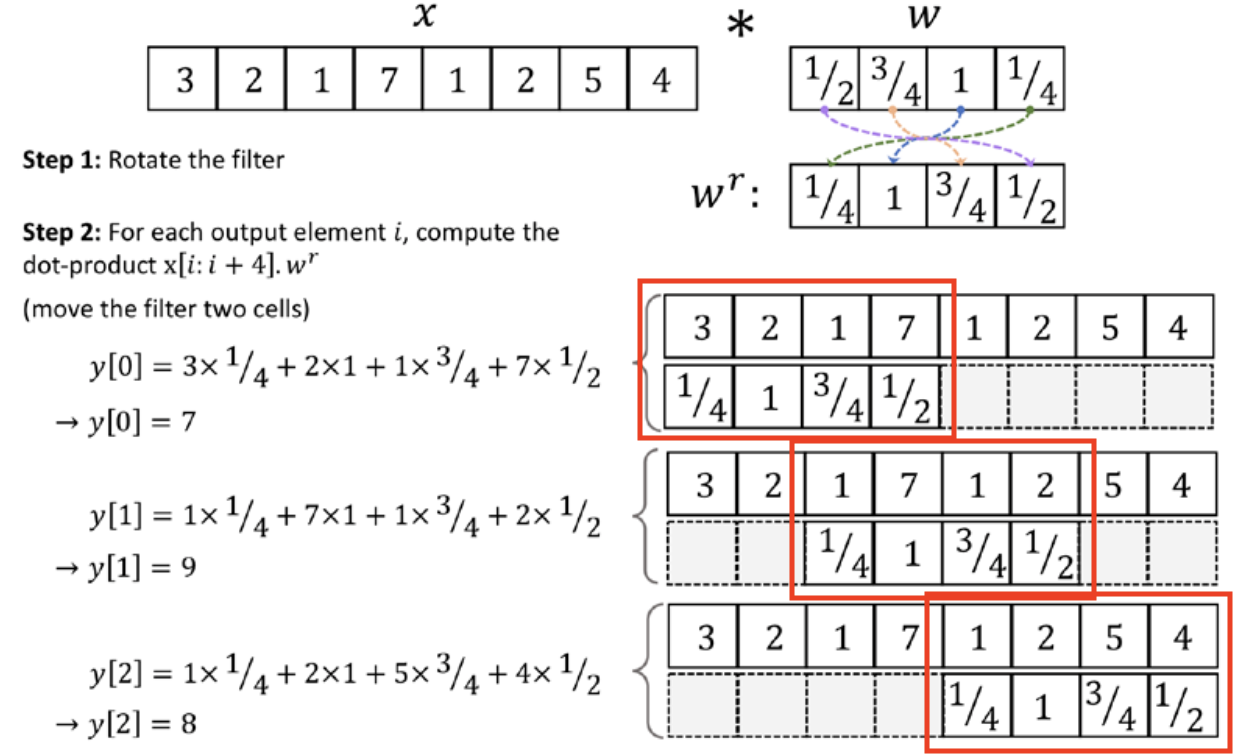'>
</center>

* $x$ is a vector with size $n=8$

* $w$ and $w^{r}$ are vectors with size $m=4$

* Each of the three dot products (red rectangles) have $m=4$ multiplications, creating three output scalars $y[i]$ for $i=0, 1, 2$

* The vector $w^{r}$ is shifted by two cells each time we shift, which is a hyperparameter of a convolution called the **stride**, $s$. In this example, the stride is $s = 2$. Note that the stride has to be a positive number *smaller than the size of the input vector*.

#### Cross-Correlation

The cross-correlation between an input vector and a filter is denoted by $\boldsymbol{y}=\boldsymbol{x} \star \boldsymbol{w}$ and is much like a convolution, with a small difference: in cross-correlation, the multiplication is performed in the same direction. Therefore, it is not a requirement to rotate the filter matrix or vector, $w$, in each dimension. Mathematically, the cross-correlation is defined as follows:

$$
\boldsymbol{y}=\boldsymbol{x} \star \boldsymbol{w} \rightarrow y[i]=\sum_{k=-\infty}^{+\infty} x[i+k] w[k]
$$

The same rules for padding and stride may be applied to cross-correlation as well. Note that most deep learning frameworks (including PyTorch) implement cross-correlation but refer to it as convolution, which is a common convention in the deep learning field.

### Padding

There are three modes of padding that are often used in practice: full, same, and valid.

In **full** mode, the padding parameter, $p$, is set to $p = m – 1$ where $m$ is the size of the kernel. Full padding increases the dimensions of the output; thus, it is rarely used in CNN architectures.

The **same** padding mode is usually used to ensure that the output vector has the same size as the input vector, $x$. In this case, the padding parameter, $p$, is computed according to the filter size, along with the requirement that the input size and output size are the same.

Finally, computing a convolution in **valid** mode refers to the case where $p = 0$ (no padding).



<center>
<image width=620 height=200 src='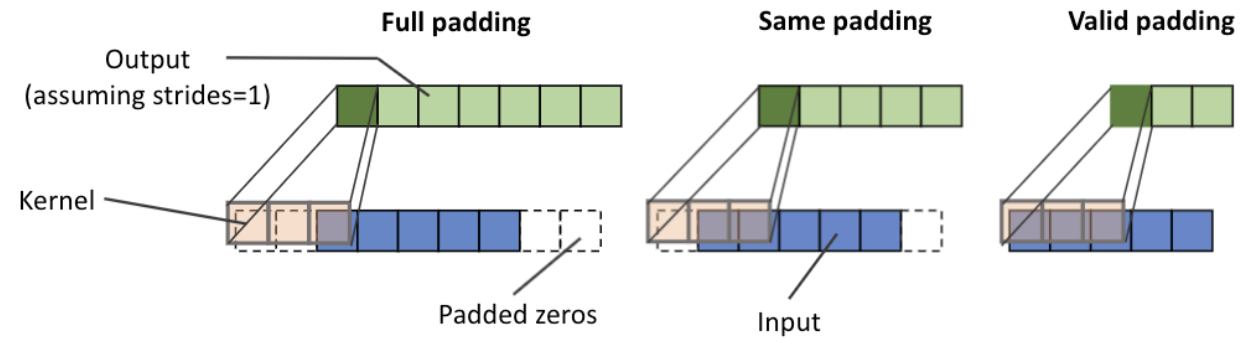'>
</center>

The above example demonstrates various padding modes for a $5\times1$ input with a $3\times1$ kernel and a stride of $1$.

* Full padding adds $p=3-1=2$ zeros to each end of the input and results in an output vector with size $7$, increasing the dimension of the output

* Same padding adds just enough zero(s), in this case $p=1$, so that the output vector has the same dimension as the input

* Valid padding adds no padding and results in an output vector that has size dependent on the stride $s$ and the input dimension $x$.

### Size of Convolution Output

The output size of a convolution is determined by the total number of times that we shift the filter, $w$, along the input vector. Suppose that the input vector is of size $n$ and the filter is of size $m$. Then, the size of the output resulting from $\boldsymbol{y}=\boldsymbol{x} * \boldsymbol{w}$, with padding $p$ and stride $s$, would be determined as follows:

$$
o=\left\lfloor\frac{n+2 p-m}{s}\right\rfloor+1
$$

Here, $[\cdot]$ denotes the floor operation, which returns *the largest integer that is equal to or smaller than the input*, for example:

$$
\text { floor(1.77) }=\lfloor 1.77\rfloor=1
$$

### Implementation

In [1]:
def conv_1d(
    x: Union[np.ndarray, List[Union[int, float]]],
    w: Union[np.ndarray, List[Union[int, float]]],
    p: int = 0,
    s: int = 1,
) -> np.ndarray:
    """
    Convolve a 1d array with a 1d filter or kernel.

    Parameters
    ----------
    x : 1d np.ndarray
        Input array.
    w : 1d np.ndarray
        Filter or kernel.
    p : int, optional
        Padding, by default 0.
    s : int, optional
        Stride, by default 1.

    Returns
    -------
    np.ndarray
        Output array.
    """
    # Flip the weight vector
    w_rotated = np.array(w[::-1]) if isinstance(w, list) else w[::-1]
    x_padded = np.array(x) if isinstance(x, list) else x

    # Zero padding for the input array
    if p > 0:
        # Array of zero with size p
        zero_pad = np.zeros(shape=p)
        # Concatenate the zero_pad to the beginning and end of the input array
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])

    n = len(x_padded)
    m = len(w_rotated)
    # Output array size, note that we do not need the 2p term in the numerator because we have already padded the input array x
    y_len = floor((n - m) / s) + 1
    y = np.zeros(shape=y_len)
    for i in range(0, y_len, s):
        # Element-wise multiplication where x_padded[i:i+m] and w_rotated have the same size
        y[i] = np.sum(x_padded[i : i + m] * w_rotated)

    return y.astype(np.int8)


def test_conv_1d():
    x = [1, 3, 2, 4, 5, 6, 1, 3]
    w = [1, 0, 3, 1, 2]
    print("Convolution 1D: ", conv_1d(x, w, p=2, s=1))
    print("Numpy Convolution 1D: ", np.convolve(x, w, mode="same"))


test_conv_1d()

Convolution 1D:  [ 5 14 16 26 24 34 19 22]
Numpy Convolution 1D:  [ 5 14 16 26 24 34 19 22]


### Convolutions in Two Dimensions

For 2D inputs, we have a matrix $X_{n_{1} \times n_{2}}$ and a kernel $W_{m_1 \times m_2}$ where $m_{1} \leq n_{1}$ and $m_{2} \leq n_{2}$, the matrix 

$$
Y=X*W
$$

is the result of a 2D convolution between $X$ and $W$. Note that this is not a simple matrix multiplication since the dimensions of $X$ and $W$ are different. The convolutional operation is defined as:

$$
\boldsymbol{Y}=\boldsymbol{X} * \boldsymbol{W} \rightarrow Y[i, j]=\sum_{k_1=-\infty}^{+\infty} \sum_{k_2=-\infty}^{+\infty} X\left[i-k_1, j-k_2\right] W\left[k_1, k_2\right]
$$

#### Example

<center>

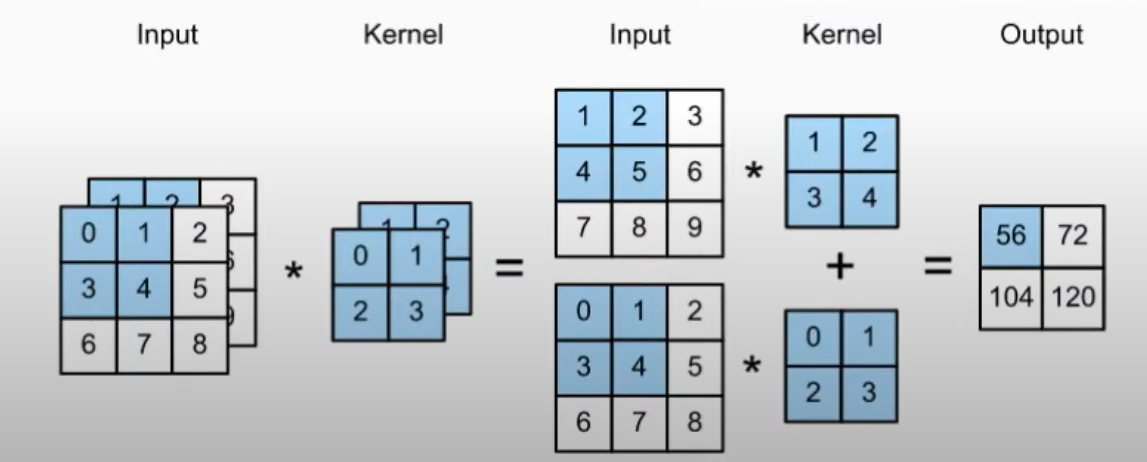

</center>

In [71]:
# Input
channel1 = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
channel2 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Stacking the channels along a new axis (last axis is the depth dimension by conventions)
X = np.stack([channel1, channel2], axis=-1)
X

# First channel
X[:, :, 0]

# Second channel
X[:, :, 1]

array([[[0, 1],
        [1, 2],
        [2, 3]],

       [[3, 4],
        [4, 5],
        [5, 6]],

       [[6, 7],
        [7, 8],
        [8, 9]]])

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [72]:
# Kernel
kernel1 = np.array([[0, 1], [2, 3]])
kernel2 = np.array([[1, 2], [3, 4]])

# Stacking the kernels along a new axis (last axis is the depth dimension by conventions)
K = np.stack([kernel1, kernel2], axis=-1)
K

# Kernel for channel 1
K[:, :, 0]

# Kernel for channel 2
K[:, :, 1]

array([[[0, 1],
        [1, 2]],

       [[2, 3],
        [3, 4]]])

array([[0, 1],
       [2, 3]])

array([[1, 2],
       [3, 4]])

With stride 1 and no zero padding, the convolutions between the first channels of the input and the kernel are as follows:

In [33]:
# Output of channel 1 and kernel 1
out_channel1_kernel1 = np.zeros(shape=(2, 2))

out_channel1_kernel1[0, 0] = 0 * 0 + 1 * 1 + 3 * 2 + 4 * 3
out_channel1_kernel1[0, 1] = 1 * 0 + 2 * 1 + 4 * 2 + 5 * 3
out_channel1_kernel1[1, 0] = 3 * 0 + 4 * 1 + 6 * 2 + 7 * 3
out_channel1_kernel1[1, 1] = 4 * 0 + 5 * 1 + 7 * 2 + 8 * 3

out_channel1_kernel1

array([[19., 25.],
       [37., 43.]])

The second channel of the input is convoluted with the second channel of the kernel:

In [34]:
# Output of channel 1 and kernel 2
out_channel1_kernel2 = np.zeros(shape=(2, 2))

out_channel1_kernel2[0, 0] = 1 * 1 + 2 * 2 + 4 * 3 + 5 * 4
out_channel1_kernel2[0, 1] = 2 * 1 + 3 * 2 + 5 * 3 + 6 * 4
out_channel1_kernel2[1, 0] = 4 * 1 + 5 * 2 + 7 * 3 + 8 * 4
out_channel1_kernel2[1, 1] = 5 * 1 + 6 * 2 + 8 * 3 + 9 * 4

out_channel1_kernel2

array([[37., 47.],
       [67., 77.]])

The feature map outputted by the kernel is summed across the channels element-wise:

In [35]:
feature_map = out_channel1_kernel1 + out_channel1_kernel2
feature_map

array([[ 56.,  72.],
       [104., 120.]])

All of the above can be computed using scipy:

In [84]:
# Initialize output feature map
output = np.zeros((2, 2))

# Perform 2D cross-correlation for each channel and add results
for i in range(X.shape[-1]):
    # Cross-correlation and sum over all channels
    output += scipy.signal.correlate2d(X[:, :, i], K[:, :, i], mode="valid")

output

array([[ 56.,  72.],
       [104., 120.]])

If we need to use the convolution function, we need to rotate the kernel:

In [86]:
K_rotated = K[::-1, ::-1]

output = np.zeros((2, 2))

for i in range(X.shape[-1]):
    output += scipy.signal.convolve2d(X[:, :, i], K_rotated[:, :, i], mode="valid")

output

array([[ 56.,  72.],
       [104., 120.]])

## Multi-Channel Convolution

The example above demonstrates the steps to performing convolution operation when there are multiple channels:

> We perform the convolution operation for each channel separately and then add the results together using matrix summation. The convolution associated with each channel $C$ has its own kernel matrix W[:, :, C].

### Single Feature Map 

Given a training example 

$$X_{n_{1} \times n_{2} \times C_{in}}$$

a kernel array

$$W_{m_{1} \times m_{2} \times C_{in}}$$

and a bias value $b$, the total pre-activation result is computed in the following formula:

\begin{align*}
\boldsymbol{Z}^{\text{Conv}} & = \sum_{c=1}^{c_{i n}} \boldsymbol{W}[:,:, c] * \boldsymbol{X}[:,:, c] \\
\\
\text{Pre-activation:} \quad \boldsymbol{Z} & = \boldsymbol{Z}^{\text{Conv}} + b_c \\
\\
\text{Feature map:} \quad \boldsymbol{A} & = \sigma(\boldsymbol{Z})
\end{align*}

where:

* $\boldsymbol{W}[:,:, c]$ and $\boldsymbol{X}[:,:, c] $ are two-dimensional arrays (matrices)
* $b_c$ is the bias value for each input channel
* $A$ is a feature map with non-linearity $\sigma$

### Multiple Feature Maps

If we have multiple input feature maps, the kernel tensor becomes four-dimensional--- width $\times$ height $\times C_{in} \times C_{\text {out}}$:

* width $\times$ height is the kernel or filter size
  
* $C_{\text{in}}$ is the number of input channels 
  
* $C_{\text{out}}$ is the number of output feature maps.

Therefore, given a training example 

$$X_{n_{1} \times n_{2} \times C_{in}}$$

a kernel array

$$W_{m_{1} \times m_{2} \times C_{in} \times C_{out}}$$

and a bias **vector** $b_{C_{out}}$, the total pre-activation result is computed in the following formula:

\begin{align*}
\boldsymbol{Z}^{\text{Conv}}[:,:, k] & = \sum_{c=1}^{C_{i n}} \boldsymbol{W}[:,:, c, k] * \boldsymbol{X}[:,:, c] \\
\\
\boldsymbol{Z}[:,:, k] & = \boldsymbol{Z}^{\text{Conv}}[:,:, k] + b[k] \\
\\
\boldsymbol{A}[:,:, k] & = \sigma(\boldsymbol{Z}[:,:, k]) \\
\end{align*}

where $k$ indexes the channels of the output array. Put it another way, $k$ is the number of output feature maps for the convolutional layer.

### Example

<center>

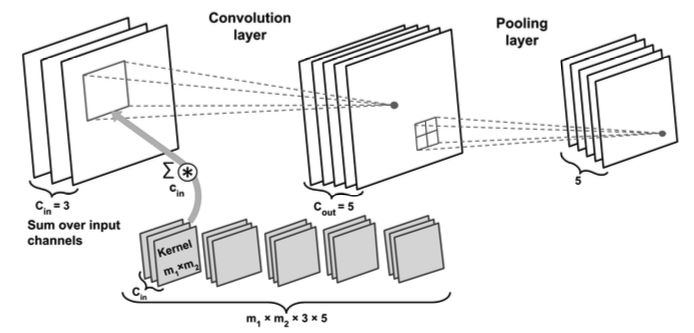

</center>

In this example, there are three input channels. The kernel tensor is four-dimensional. Each kernel matrix is denoted as $m_1 \times m_2$, and there are three of them, one for each input channel. Furthermore, there are five such kernels $m_{1} \times m_{2} \times 3$, accounting for five output feature maps. Finally, there is a pooling layer for subsampling the feature maps.

* $m_1 \times m_2$ are the kernel dimensions

* $C_{in}=3$ is the number of input channels

* $C_{out}=5$ is the number of output channels or feature maps


### Number of Trainable Parameters

The convolutional layer above has $m_{1} \times m_{2} \times 3 \times 5$ parameters associated with the kernel. In addition, there is a bias vector containing one bias term for each of the output feature map of the layer (so 5). Therefore, the total number of trainable parameters of the layer is:

$$(m_{1} \times m_{2} \times 3 \times 5) + 5$$

As a comparison, if fully connected layers are used, then the number of parameters for the weight matrix to reach the same number of output units would have been:

$$\left(n_1 \times n_2 \times 3\right) \times\left(n_1 \times n_2 \times 5\right)=\left(n_1 \times n_2\right)^2 \times 3 \times 5$$

### Size of Output Feature Map

If the input tensor is of size $n_{1} \times n_{2} \times 3$ (3 feature maps or channels) and assuming that the convolution is performed with same-padding mode (i.e., output feature maps have the same dimensions as the input feature maps), then the size of the output feature maps would be $n_{1} \times n_{2} \times 5$ (5 feature maps or channels). 

In general, when

- $n_1=x$ and $n_2=y$ are the input dimensions (assuming equal dimensions)
- $k_h=m_1=i$ and $k_w=m_2=j$ are the filter or kernel dimensions (usually assumed to have same dimensions so we can simply use $k$)
- $p_{\text {start}}$ is the padding applied to the start of the input
- $p_{\text {end }}$ is the padding applied to the end of the input
- $s$ is the stride length
  
The output sizes of the feature map $o_1$ and $o_2$, if they are different, are given by:

$$
o_1=\frac{n_1-k+p_{\text {start }}+p_{\text{end}}}{s}+1
$$

and

$$
o_2=\frac{n_2-k+p_{\text {start }}+p_{\text{end}}}{s}+1
$$

---

* **Valid Padding (No Padding)**: In this case, no padding is applied, so $p_{\text {start }}=p_{\text {end }}=0$:

    $$
    o_1=\frac{n_1-k+0+0}{s}+1=\frac{n_1-k}{s}+1
    $$

    and

    $$
    o_2=\frac{n_2-k+0+0}{s}+1=\frac{n_2-k}{s}+1
    $$

* **Same Padding**: For same padding, the padding is chosen such that the output size is the same as the input size when the stride is 1. In other words, we want $o_1=n_1$ and $o_2=n_2$. If we set $s=1$ and solve the general formula for $p_{\text {start }}$ and $p_{\text {end }}$, we get:

    $$
    p_{\text {start }}+p_{\text {end }}=k-1
    $$
    
    To see this, start with the general formula using $n_1$ as an example ($n_2$ is the same):

    $$
    o_1=\frac{n_1-k+p_{\text {start }}+p_{\text {end }}}{s}+1
    $$

    Since we're considering 'same' padding, we want the output size $o_1=n_1$, and we're assuming a stride $s$ of 1. Substituting these values into the equation gives:

    $$
    \begin{aligned}
    n_1 & =\frac{n_1-k+p_{\text {start }}+p_{\text{end }}}{1}+1 \\
    n_1-1 & =n_1-k+p_{\text {start }}+p_{\text {end }} \\
    \cancel{n_1} -1 - \cancel{n_1} + k& =p_{\text {start }}+p_{\text {end }} \\
    k-1 & =p_{\text {start }}+p_{\text {end }}
    \end{aligned}
    $$

    In the case of 'same' padding, we typically assume symmetric padding, so $p_{\text {start }}=p_{\text {end}}=2p$. Since $k-1=p_{\text{start}}+p_{\text{end}}=2p$, the formula becomes:

    $$
    o_1=\frac{n_1-k+(k-1)}{s}+1=\frac{n_1-1}{s}+1
    $$

    When stride $s=1$, this simplifies to:
    $$
    o_1=n_1
    $$
    Again, $n_2$ is the same:
    $$
    o_2=\frac{n_2-k+(k-1)}{s}+1=\frac{n_2-1}{s}+1
    $$
    and when $s=1$:
    $$
    o_2=n_2
    $$
    

#### Non-unit Strides

The most general case (convolving over a zero padded input using non-unit strides) uses the following formula to compute the output sizes $o_1$ and $o_2$. For any $n, k, p$ (square input, symmetric padding, and square kernel) and $s$,
$$
o=\left\lfloor\frac{n+2 p-k}{s}\right\rfloor+1
$$
As before, the floor function means that in some cases a convolution will produce the same output size for multiple input sizes. More specifically, if $n+2p-k$ is a multiple of $s$, then any input size $j=n+a, \quad a \in\{0, \ldots, s-1\}$ will produce the same output size. Note that this ambiguity applies only for $s>1$.

## Subsampling Layer

Subsampling is typically applied in two forms of pooling operations in CNNs: **max-pooling** and **average-pooling**. The pooling layer is usually denoted by $P_{n_1 \times n_2}$. Here, the subscript determines the size of the neighborhood (the number of adjacent pixels in each dimension) where the max or mean operation is performed. We refer to such a neighborhood as the **pooling size**.

<center>

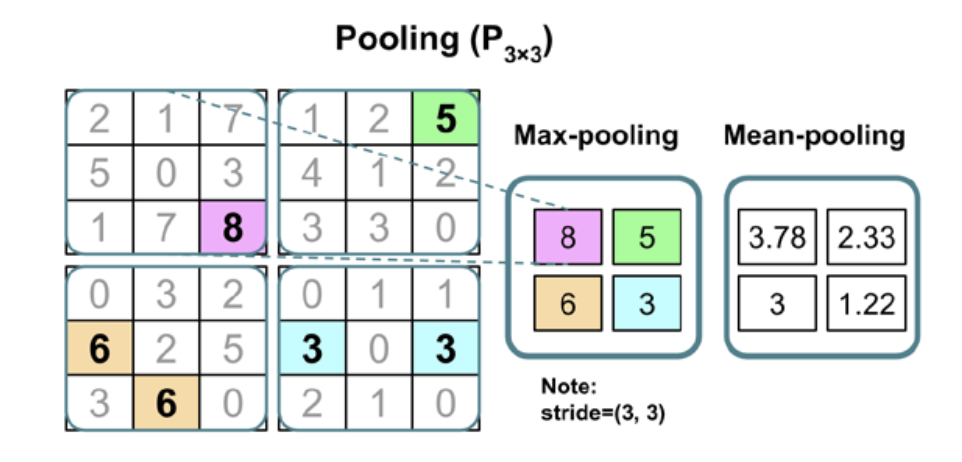

</center>

The advantages of pooling is twofold:

* Pooling (max-pooling) introduces a local invariance. This means that small changes in a local neighborhood do not change the result of max-pooling. Therefore, it helps with generating features that are more robust to noise in the input data. As an example, max-pooling of two different input matrices, X1 and X2, results in the same output:

In [21]:
# X_1
X_1 = np.array(
    [
        [10, 255, 125, 0, 170, 100],
        [70, 255, 105, 25, 25, 70],
        [255, 0, 150, 0, 10, 10],
        [0, 255, 10, 10, 150, 20],
        [70, 15, 200, 100, 95, 0],
        [35, 25, 100, 20, 0, 60],
    ]
)
# X_2
X_2 = np.array(
    [
        [100, 100, 100, 50, 100, 50],
        [95, 255, 100, 125, 125, 170],
        [80, 40, 10, 10, 125, 150],
        [255, 30, 150, 20, 120, 125],
        [30, 30, 150, 100, 70, 70],
        [70, 30, 100, 200, 70, 95],
    ]
)
# Add batch dimensions
X1_tensor = torch.from_numpy(X_1).float().unsqueeze(0)
X2_tensor = torch.from_numpy(X_2).float().unsqueeze(0)
# Max pooling
max_pooling_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
max_pooling_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

In [22]:
# Apply max pooling
Y1 = max_pooling_1(X1_tensor)
Y2 = max_pooling_2(X2_tensor)

# Convert to numpy
Y1.numpy()
Y2.numpy()

array([[[255., 125., 170.],
        [255., 150., 150.],
        [ 70., 200.,  95.]]], dtype=float32)

array([[[255., 125., 170.],
        [255., 150., 150.],
        [ 70., 200.,  95.]]], dtype=float32)

* Pooling decreases the size of features, which results in higher computational efficiency. Furthermore, reducing the number of features may reduce the degree of overfitting as well.


### Overlapping V.S. Non-overlapping

Traditionally, pooling is assumed to be non-overlapping. Pooling is typically performed on non-overlapping neighborhoods, which can be done by setting the stride parameter equal to the pooling size or `kernel_size`. For example, a non-overlapping pooling layer, $P_{n_1 \times n_2}$, requires a stride parameter $s=\left(n_1, n_2\right)$. On the other hand, overlapping pooling occurs if the stride is smaller than the pooling size. 